In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator
import numpy as np

# find government bond yields for different maturities 

tickers = {'^IRX':0.25, '^FVX':5.0, '^TNX': 10.0, '^TYX': 30.0}
govt_bond_yields = yf.download(list(tickers.keys()), period='1d')['Close'].iloc[-1]
ruler = pd.DataFrame({'Maturity': list(tickers.values()), 'Yield': govt_bond_yields.values})

# since no tickers exist for govt bonds with 1,2, and 20 year maturities, manually input futures yields as of January 5, 2026

manually_input_data = pd.DataFrame({'Maturity': [1.0, 2.0, 20.0], 'Yield': [3.48, 3.50, 4.45]})
ruler = pd.concat([ruler, manually_input_data]).sort_values('Maturity').reset_index(drop=True)

[*********************100%***********************]  4 of 4 completed


In [2]:
# simulate bond portfolio

symbols = ['AAPL','MSFT', 'DIS', 'F', 'AMZN'] # borrowers
years = [5.0, 2.0, 10.0, 3.0, 7.0] # bond maturity, range from 2.0 to 10.0 years ensures PchipInterpolator works across entire yield curve, stimulate laddered portfolio where cash continues coming in at diff times
portfolio = pd.DataFrame({'Ticker': symbols, 'Years': years})

# from govt bond yield data, interpolate govt bond yields for the different bond maturities 

curve_logic = PchipInterpolator(ruler['Maturity'], ruler['Yield'])
portfolio['Govt_Yield_%'] = curve_logic(portfolio['Years'])

# using beta as a risk proxy, calculate credit spread

betas = []
for s in symbols:
    beta = yf.Ticker(s).info.get('beta', 1.0)
    betas.append(beta)
portfolio['Beta'] = betas

# assume 1.0 beta = 1% credit spread

risk_multiplier = 1.0
portfolio['Spread_%'] = portfolio['Beta'] * risk_multiplier

portfolio['Total_Yield_%'] = portfolio['Govt_Yield_%'] + portfolio['Spread_%']

--- PORTFOLIO ---
  Ticker  Govt_Yield_%  Spread_%  Total_Yield_%
0   AAPL          3.52      1.09           4.61
1   MSFT          3.50      1.07           4.57
2    DIS          4.14      1.44           5.58
3      F          3.51      1.63           5.14
4   AMZN          3.72      1.38           5.09


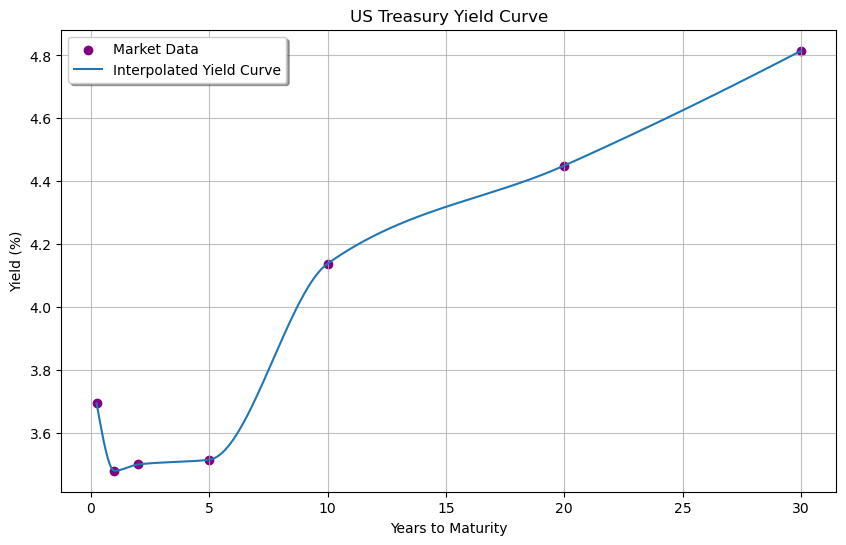

In [3]:
# plot yield curve and visualize portfolio

plt.figure(figsize=(10,6))
plt.scatter(ruler['Maturity'], ruler['Yield'], color='purple', label='Market Data')
dense_x = np.linspace(0.25, 30.0, 500) # plot 500 points from 0.25 yrs to 30.0 years
dense_y = curve_logic(dense_x) # interpolated y values 
plt.plot(dense_x, dense_y, label='Interpolated Yield Curve')
plt.legend(loc='upper left', shadow=True)
plt.grid(True, alpha=0.8)
plt.title('US Treasury Yield Curve')
plt.xlabel('Years to Maturity')
plt.ylabel('Yield (%)')

print('--- PORTFOLIO ---')
print(portfolio[['Ticker', 'Govt_Yield_%', 'Spread_%', 'Total_Yield_%']].round(2))

In [4]:
# calculate bond price

def bond_price(years, ytm, face_value=100, coupon_rate=0.05):
    price = 0
    ytm = ytm / 100
    coupon_payment = coupon_rate * face_value
    
    for year in range(1, int(years) + 1):
        if year == years:
            cash_flow = face_value + coupon_payment
        else:
            cash_flow = coupon_payment
        
        present_value = cash_flow / ((1+ytm)**year)
        
        price += present_value
        
    return price 

In [5]:
# calculate bond price sensitivity to I/R change (effective duration)

def duration(years, ytm, face_value=100, coupon_rate=0.05):
    
    original_price = bond_price(years, ytm, face_value, coupon_rate)
    price_if_rates_fall = bond_price(years, ytm - 0.5, face_value, coupon_rate)
    price_if_rates_rise = bond_price(years, ytm + 0.5, face_value, coupon_rate)

    effective_duration = (price_if_rates_fall - price_if_rates_rise) / (2 * original_price * 0.005)

    return effective_duration

In [6]:
# calculate price & duration for each bond in portfolio

portfolio['Price'] = portfolio.apply(lambda x: bond_price(x['Years'], x['Total_Rate_%']), axis = 1) 

portfolio['Duration'] = portfolio.apply(lambda x: duration(x['Years'], x['Total_Rate_%']), axis = 1)

print("--- VALUATION & SENSITIVITY ---")
print(portfolio[['Ticker', 'Total_Rate_%', 'Price', 'Duration']].round(2))

KeyError: 'Total_Rate_%'

<function matplotlib.pyplot.show(close=None, block=None)>

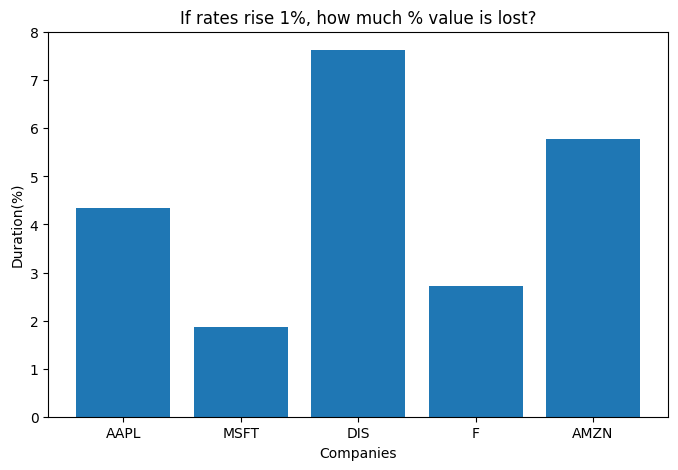

In [ ]:
# visualize duration 

plt.figure(figsize=(8,5))
plt.bar(portfolio['Ticker'], portfolio['Duration'])
plt.title("If rates rise 1%, how much % value is lost?")
plt.xlabel("Companies")
plt.ylabel("Duration(%)")
plt.show

In [ ]:
# Monte Carlo Simulation 

# generate 1000 I/R 'futures'

current_rate = ruler['Yield'].mean()
volatility = 0.02 # standard dev, historical annual volatility of US treasury yields
mean_conversion_rate = 0.1 # mimics how Fed Reserve allows for market noise while ensuring economy stays within realistic boundary
number_of_simulations = 1000

np.random.seed(42)
rate_shocks = np.random.normal(0, volatility, number_of_simulations)

In [ ]:
# vectorization, portfolio value after rate shocks 

# define function 

def simulated_portfolio_value(shock, portfolio):
    value = 0
    # account for cases of bond default
    bond_default = np.random.random()
    recovery_rate = 1
    if bond_default < 0.01:
        recovery_rate = 0.40
    shock = shock / 100
    
    price_change = -portfolio['Duration'] * portfolio['Price'] * shock 
    if recovery_rate == 1:
        new_price = portfolio['Price'] + price_change 
    else:
        new_price = portfolio['Price'] * recovery_rate
        
    return new_price.sum()

# apply function and store in series

simulated_portfolio = pd.Series([simulated_portfolio_value(s, portfolio) for s in rate_shocks])

In [ ]:
# find VaR (assume losses with 5% probability over 1 year)

initial_portfolio_value = portfolio['Price'].sum()
losses = initial_portfolio_value - simulated_portfolio
VaR = np.percentile(losses, 95)

print(f"Starting Portfolio Value: ${initial_portfolio_value:.2f}")
print(f"95% Value at Risk (VaR): ${VaR:.2f}")
print(f"In the worst 5% of cases, you lose at least ${VaR:.2f} over the next year.")

Starting Portfolio Value: $495.38
95% Value at Risk (VaR): $0.78
In the worst 5% of cases, you lose at least $0.78 over the next year.


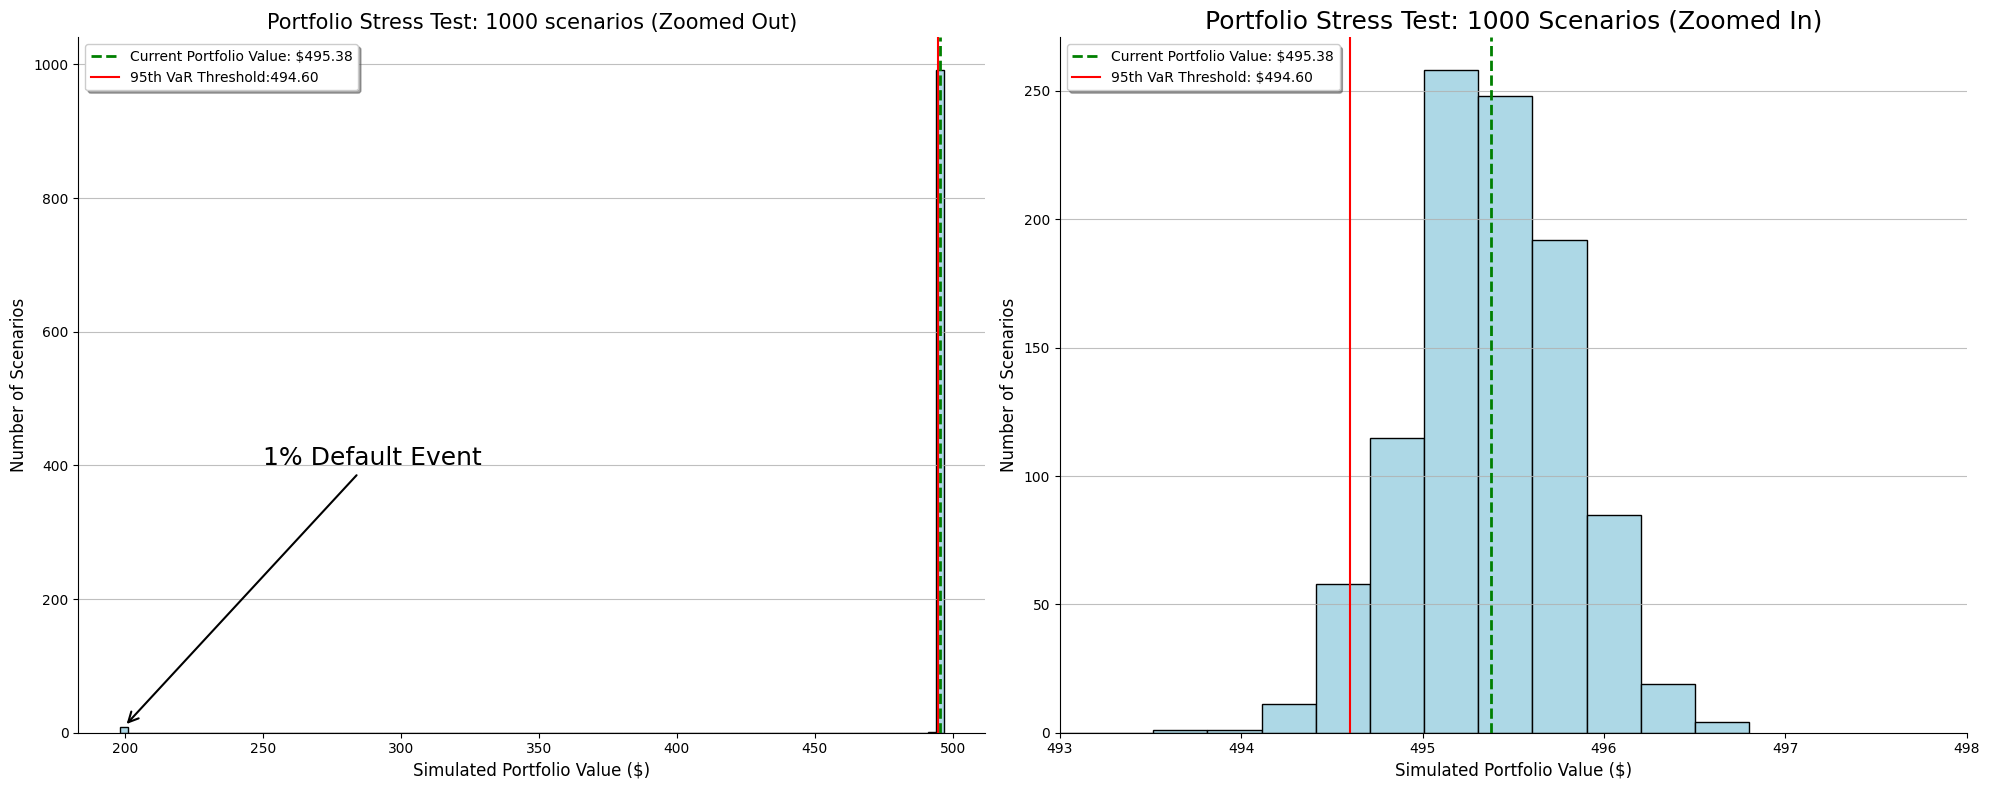

In [ ]:
# visualize simulated portfolio, current portfolio, VaR, and default event

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,8))

ax1.hist(simulated_portfolio, bins=100, color='lightblue', edgecolor='black')
ax1.axvline(initial_portfolio_value, linestyle='--', lw=2, color='green', label=f'Current Portfolio Value: ${initial_portfolio_value:.2f}')
ax1.axvline(initial_portfolio_value - VaR, color='red', label=f'95th VaR Threshold:{initial_portfolio_value-VaR:.2f}')
ax1.legend(loc='upper left', shadow=True)
ax1.annotate('1% Default Event', xy=(200,10), xytext=(250,400), arrowprops=dict(arrowstyle='->', color='black', lw=1.5), fontsize=18)
ax1.grid(axis='y', alpha=0.8)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('Portfolio Stress Test: 1000 scenarios (Zoomed Out)', fontsize=15)
ax1.set_xlabel('Simulated Portfolio Value ($)',fontsize=12)
ax1.set_ylabel('Number of Scenarios',fontsize=12)

ax2.hist(simulated_portfolio, bins=1000, color='lightblue', edgecolor='black')
ax2.axvline(initial_portfolio_value, linestyle='--', lw=2, color='green', label=f'Current Portfolio Value: ${initial_portfolio_value:.2f}')
ax2.axvline(initial_portfolio_value-VaR, color='red', label=f'95th VaR Threshold: ${initial_portfolio_value-VaR:.2f}')
ax2.legend(loc='upper left', shadow=True)
ax2.grid(axis='y', alpha=0.8)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_title('Portfolio Stress Test: 1000 Scenarios (Zoomed In)', fontsize=18)
ax2.set_xlabel('Simulated Portfolio Value ($)', fontsize=12)
ax2.set_ylabel('Number of Scenarios', fontsize=12)
ax2.set_xlim(493,498)            

plt.tight_layout()
plt.show()


In [ ]:
# portfolio health grade

def health_grade(percentage_risk):
    if percentage_risk < 3:
        return "CONSERVATIVE (safe)"
    elif percentage_risk < 6:
        return "MODERATE (balanced)"
    else:
        return "AGGRESSIVE (high risk)"
    
var_percent = (VaR / initial_portfolio_value) * 100
portfolio_health = health_grade(var_percent)
print(f'PORTFOLIO HEALTH GRADE: {portfolio_health}')

PORTFOLIO HEALTH GRADE: CONSERVATIVE (safe)


In [ ]:
# Macaulay (weighted avg) duration; how the whole portfolio moves together 

portfolio['Weight'] = portfolio['Price'] / initial_portfolio_value
weighted_average_duration = (portfolio['Duration'] * portfolio['Weight']).sum()

# dashboard 

summary_data = {'Metric': ['Total Portfolio Value', 'Weighted-Average Duration', '95% Value at Risk', 'Portfolio Risk', 'Worst-Case Outcome'],
            'Value': [f'${initial_portfolio_value:.2f}', f'{weighted_average_duration:.2f} years', f'${VaR:.2f}', f'{var_percent:.2f}%', f'${initial_portfolio_value-VaR:.2f}']}
dashboard = pd.DataFrame(summary_data)
print('--- EXECUTIVE RISK DASHBOARD ---')
print(dashboard)

--- EXECUTIVE RISK DASHBOARD ---
                      Metric       Value
0      Total Portfolio Value     $495.38
1  Weighted-Average Duration  4.43 years
2          95% Value at Risk       $0.78
3             Portfolio Risk       0.16%
4         Worst-Case Outcome     $494.60


In [ ]:
# finding riskiest bond 

top_risk_bond = portfolio.loc[portfolio['Duration'].idxmax()]
print('--- RISK ATTRIBUTION ---')
print(f'Highest Interest Rate Risk: {top_risk_bond['Ticker']} ({top_risk_bond['Duration']:.2f} yrs)')

--- RISK ATTRIBUTION ---
Highest Interest Rate Risk: DIS (7.62 yrs)
